In [6]:
import glob
import os
import shutil
from PIL import Image 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from modules.scandata import MriScan, MriSlice, TumourSegmentation, ScanType, ScanPlane, PatientRecord

In [2]:
data_dir = os.path.join('data','mri-datasets','first-20-testset','dataset_multiseq')
tumour_data_dir = os.path.join(data_dir, 'tumour')
healthy_data_dir = os.path.join(data_dir, 'healthy')
try:
    os.mkdir(data_dir)
except FileExistsError:
    print('Directory exists')
try:
    os.mkdir(tumour_data_dir)
except FileExistsError:
    print('Directory exists')
try:
    os.mkdir(healthy_data_dir)
except FileExistsError:
    print('Directory exists')

In [7]:
for patient in range(1,21):

    T1_scan = MriScan(
        filename=f'data/mri-datasets/first-20-testset/images_structural/UPENN-GBM-{patient:05}_11/UPENN-GBM-{patient:05}_11_T1.nii.gz',
        sequence=ScanType.T1
    )
    T1CE_scan = MriScan(
        filename=f'data/mri-datasets/first-20-testset/images_structural/UPENN-GBM-{patient:05}_11/UPENN-GBM-{patient:05}_11_T1GD.nii.gz',
        sequence=ScanType.T1CE
    )
    T2_scan = MriScan(
        filename=f'data/mri-datasets/first-20-testset/images_structural/UPENN-GBM-{patient:05}_11/UPENN-GBM-{patient:05}_11_T2.nii.gz',
        sequence=ScanType.T2
    )
    FLAIR_scan = MriScan(
        filename=f'data/mri-datasets/first-20-testset/images_structural/UPENN-GBM-{patient:05}_11/UPENN-GBM-{patient:05}_11_FLAIR.nii.gz',
        sequence=ScanType.FLAIR
    )
    segmentation = TumourSegmentation(
        filename=f'data/mri-datasets/first-20-testset/automated_segm/UPENN-GBM-{patient:05}_11_automated_approx_segm.nii.gz',
        )

    patient_data = PatientRecord()
    patient_data.add_scan_data(T1_scan)
    patient_data.add_scan_data(T1CE_scan)
    patient_data.add_scan_data(T2_scan)
    patient_data.add_scan_data(FLAIR_scan)
    patient_data.add_segmentation(segmentation)

    patient_data.save_multi_channel_png(os.path.join(data_dir, f'UPENN-GBM-{patient:05}_11_multiseq'), [ScanType.T2,ScanType.T1CE, ScanType.FLAIR,ScanType.T1])

In [8]:
data_list = []
for auto_seg in glob.glob('data/mri-datasets/first-20-testset/automated_segm/UPENN-GBM-*_11_automated_approx_segm.nii.gz'):
    patient = auto_seg.removeprefix('data/mri-datasets/first-20-testset/automated_segm/UPENN-GBM-')[:5]
    segmentation = TumourSegmentation(auto_seg)
    for idx, slice in enumerate(segmentation.iterate_slices()):
        data_list.append([patient, idx, 1 if 1 in slice.slice_data  else 0])


In [9]:
df = pd.DataFrame(data_list, columns=['patient', 'slice', 'tumour_present'])

In [10]:
df.tumour_present.value_counts()

0    2428
1     672
Name: tumour_present, dtype: int64

In [11]:
print(df)


     patient  slice  tumour_present
0      00018      0               0
1      00018      1               0
2      00018      2               0
3      00018      3               0
4      00018      4               0
...      ...    ...             ...
3095   00014    150               0
3096   00014    151               0
3097   00014    152               0
3098   00014    153               0
3099   00014    154               0

[3100 rows x 3 columns]


In [16]:
# Arrange data set in directories for different classes
for idx, row in df.iterrows():
    patient_number = row['patient']
    slice_number = row['slice']
    filename = f'UPENN-GBM-{int(patient_number):05}_11_multiseq_{int(slice_number):03}.png'
    original_file = os.path.join(data_dir, filename)
    if row['tumour_present']:
        new_file = os.path.join(tumour_data_dir, filename)
    else:
        new_file = os.path.join(healthy_data_dir, filename)
    shutil.copyfile(original_file, new_file)
        

In [18]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [19]:
batch_size = 32
img_height = 240
img_width = 240

In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3100 files belonging to 2 classes.
Using 2480 files for training.
Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-16 13:27:56.695557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-16 13:27:56.696357: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    color_mode="rgba",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 3100 files belonging to 2 classes.
Using 620 files for validation.


In [22]:
class_names = train_ds.class_names
print(class_names)

['healthy', 'tumour']


In [23]:
train_ds.list_files

<function tensorflow.python.data.ops.dataset_ops.DatasetV2.list_files(file_pattern, shuffle=None, seed=None, name=None)>

2022-11-16 13:28:50.278479: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


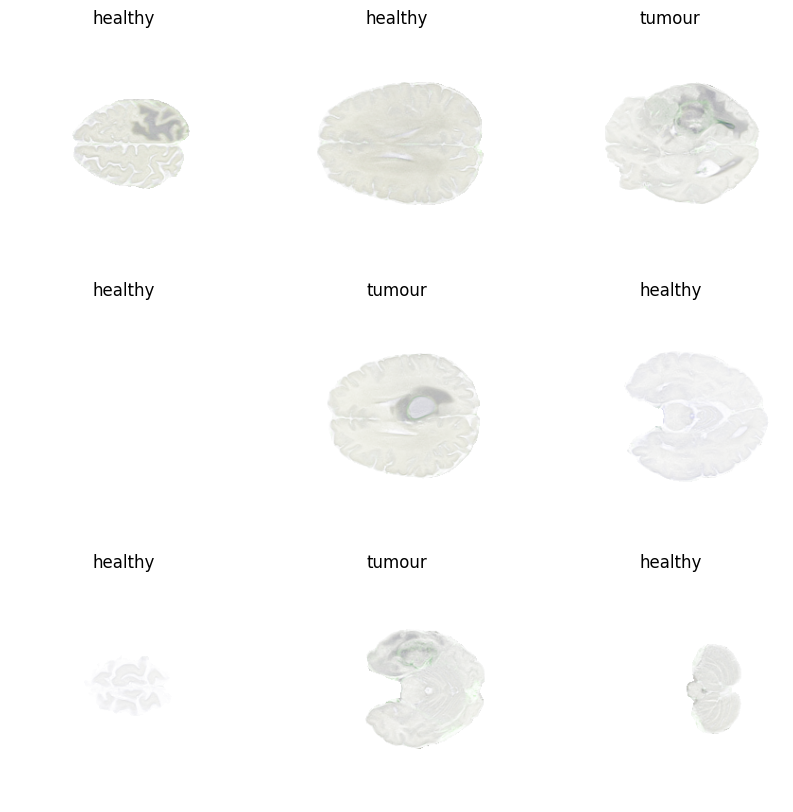

In [24]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [25]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 240, 240, 4)
(32,)


In [26]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
normalization_layer = layers.Rescaling(1./(2**8-1))

In [28]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./(2**8-1), input_shape=(img_height, img_width, 4)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [29]:
df.tumour_present.value_counts()

0    2428
1     672
Name: tumour_present, dtype: int64

In [30]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 240, 240, 4)       0         
                                                                 
 conv2d (Conv2D)             (None, 240, 240, 16)      592       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 120, 120, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        1

In [32]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10


2022-11-16 13:32:46.105367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - ETA: 0s - loss: 0.4098 - accuracy: 0.7851

2022-11-16 13:33:00.922503: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 16s 153ms/step - loss: 0.4098 - accuracy: 0.7851 - val_loss: 0.3545 - val_accuracy: 0.8226
Epoch 2/10
78/78 [==============================] - 12s 148ms/step - loss: 0.2596 - accuracy: 0.8843 - val_loss: 0.2015 - val_accuracy: 0.9306
Epoch 3/10
78/78 [==============================] - 11s 146ms/step - loss: 0.1268 - accuracy: 0.9516 - val_loss: 0.1154 - val_accuracy: 0.9629
Epoch 4/10
78/78 [==============================] - 12s 148ms/step - loss: 0.0743 - accuracy: 0.9726 - val_loss: 0.0627 - val_accuracy: 0.9823
Epoch 5/10
78/78 [==============================] - 12s 150ms/step - loss: 0.0874 - accuracy: 0.9734 - val_loss: 0.0862 - val_accuracy: 0.9710
Epoch 6/10
78/78 [==============================] - 12s 148ms/step - loss: 0.0667 - accuracy: 0.9782 - val_loss: 0.0932 - val_accuracy: 0.9645
Epoch 7/10
78/78 [==============================] - 12s 150ms/step - loss: 0.0496 - accuracy: 0.9855 - val_loss: 0.0906 - val_accuracy: 0.9726
Epoch 8/10

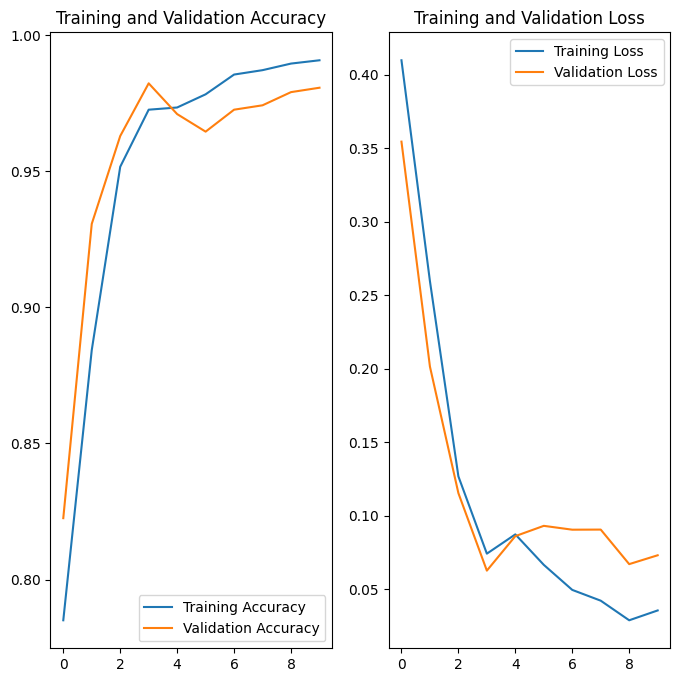

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  1)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)



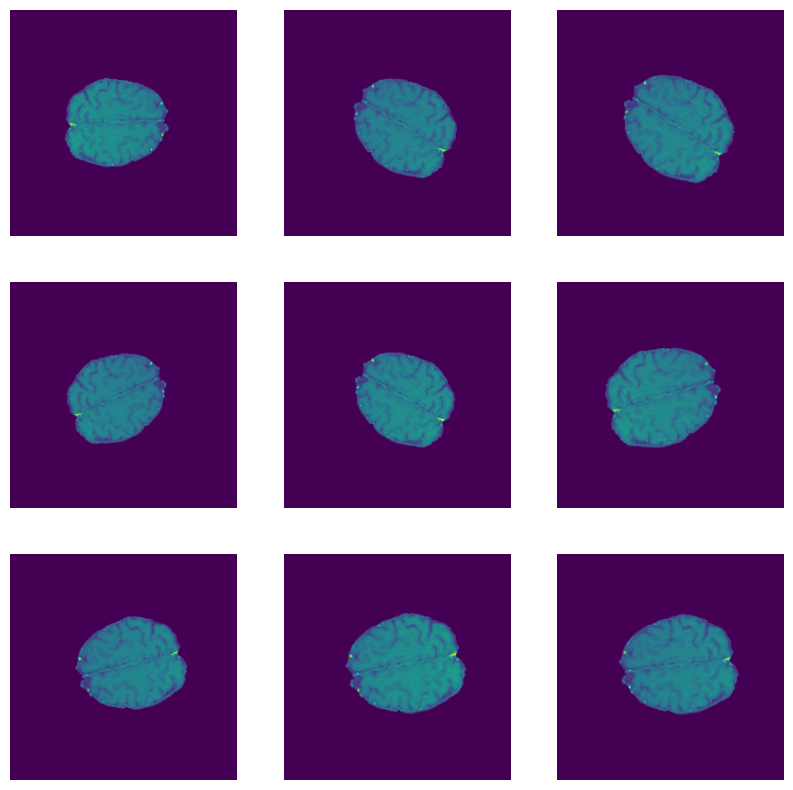

In [26]:

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    #with tf.device('/CPU:0'):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [ ]:
tf.config.list_physical_devices()

In [27]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./(2**16-1)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [28]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [29]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 240, 240, 1)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 240, 240, 1)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 240, 240, 16)      160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 120, 120, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 60, 60, 32)       0         
 2D)                                                  

In [30]:
epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


2022-11-15 13:41:51.158695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - ETA: 0s - loss: 0.5459 - accuracy: 0.7839

2022-11-15 13:42:03.933144: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


78/78 [==============================] - 14s 167ms/step - loss: 0.5459 - accuracy: 0.7839 - val_loss: 0.5583 - val_accuracy: 0.7661
Epoch 2/15
78/78 [==============================] - 13s 167ms/step - loss: 0.5196 - accuracy: 0.7875 - val_loss: 0.5439 - val_accuracy: 0.7661
Epoch 3/15
78/78 [==============================] - 13s 167ms/step - loss: 0.5195 - accuracy: 0.7875 - val_loss: 0.5584 - val_accuracy: 0.7661
Epoch 4/15
78/78 [==============================] - 13s 164ms/step - loss: 0.5222 - accuracy: 0.7875 - val_loss: 0.5473 - val_accuracy: 0.7661
Epoch 5/15
78/78 [==============================] - 13s 164ms/step - loss: 0.5200 - accuracy: 0.7875 - val_loss: 0.5445 - val_accuracy: 0.7661
Epoch 6/15
78/78 [==============================] - 13s 162ms/step - loss: 0.5204 - accuracy: 0.7875 - val_loss: 0.5462 - val_accuracy: 0.7661
Epoch 7/15
78/78 [==============================] - 13s 162ms/step - loss: 0.5203 - accuracy: 0.7875 - val_loss: 0.5446 - val_accuracy: 0.7661
Epoch 8/15